### Introduction to Nilearn and image manipulation

The goal of this notebook is to help get you comfortable with manipulating functional and anatomical images using nilearn. We'll be using the techniques we learned here in our final analysis...

#### Content:
1. Basic Image Operations and Masking
2. Resampling data to work across modalities (T1/FUNC)

In [1]:
from bids import BIDSLayout

from nilearn import image as img
from nilearn import plotting as plot

#for inline visualization in jupyter notebook
%matplotlib inline 

As we've done in the past we've imported <code>image as img</code>. However, we've also imported <code>plotting as plot</code> from <code>nilearn</code>. This will allow us to easily visualize our neuroimaging data!

First let’s grab some data from where we downloaded our FMRIPREP outputs using PyBIDS:

In [2]:
#Base directory for fmriprep output
fmriprep_dir = '../data/ds000030/derivatives/fmriprep/'
layout= BIDSLayout(fmriprep_dir, validate=False)

T1w_files = layout.get(subject='10788', datatype='anat', suffix='preproc', extension='.nii.gz', return_type='file')
brainmask_files = layout.get(subject='10788', datatype='anat', suffix='brainmask', extension='.nii.gz', return_type='file')

In [3]:
#Display preprocessed files inside of anatomy folder
T1w_files

['/mnt/tigrlab/projects/mjoseph/tutorials/carpentry/SDC-BIDS-fMRI/data/ds000030/derivatives/fmriprep/sub-10788/anat/sub-10788_T1w_preproc.nii.gz',
 '/mnt/tigrlab/projects/mjoseph/tutorials/carpentry/SDC-BIDS-fMRI/data/ds000030/derivatives/fmriprep/sub-10788/anat/sub-10788_T1w_space-MNI152NLin2009cAsym_preproc.nii.gz']

## Basic Image Operations

In this section we're going to deal with the following files:

1. <code>sub-10171_T1w_preproc.nii.gz</code> - the T1 image in native space
2. <code>sub-10171_T1w_brainmask.nii.gz</code> - a mask with 1's representing the brain and 0's elsewhere.

In [4]:
t1 = T1w_files[0]
bm = brainmask_files[0]

t1_img = img.load_img(t1)
bm_img = img.load_img(bm)

First we'll do what you've been waiting to do - plot our MR image! This can be easily achieved using Nilearn's <code>plotting</code> module as follows:

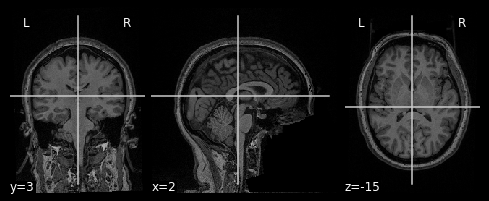

In [5]:
plot.plot_anat(t1_img)

Try viewing the mask as well!

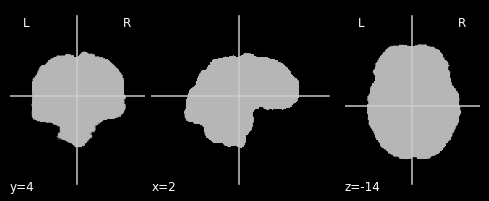

In [6]:
#View the mask image
plot.plot_anat(bm_img)

### Arithmetic Operations

Let’s start performing some image operations. The simplest operations we can perform is element-wise, what this means is that we want to perform some sort of mathematical operation on each voxel of the MR image. Since voxels are represented in a 3D array, this is equivalent to performing an operation on each element (i,j,k) of a 3D array. Let’s try inverting the image, that is, flip the colour scale such that all blacks appear white and vice-versa. To do this, we’ll use the method

<code>img.math_img(formula, **imgs)</code> Where:

- <code>formula</code> is a mathematical expression such as 'a+1'
- </code>**imgs</code> is a set of key-value pairs linking variable names to images. For example a=T1

In order to invert the image, we can simply flip the sign which will set the most positive elements (white) to the most negative elements (black), and the least positives elements (black) to the least negative elements (white). This effectively flips the colour-scale:

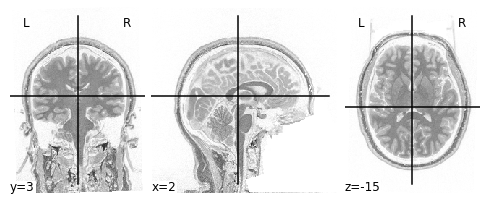

In [7]:
invert_img = img.math_img('-a', a=t1_img)
plot.plot_anat(invert_img)

Alternatively we don't need to first load in our <code>t1_img</code> using <code>img.load_img</code>. Instead we can feed in a path to <code>img.math_img</code>:

~~~
invert_img = img.math_img('-a', a=t1)
plot.plot_anat(invert_img)
~~~

This will yield the same result!

### Applying a Mask
Let’s extend this idea of applying operations to each element of an image to multiple images. Instead of specifying just one image like the following:

<code>img.math_img('a+1',a=img_a)</code>

We can specify multiple images by tacking on additional variables:

<code>img.math_img('a+b', a=img_a, b=img_b)</code>

The key requirement here is that when dealing with multiple images, that the size of the images must be the same. The reason being is that we’re deaing with element-wise operations. That means that some voxel (i,j,k) in img_a is being paired with some voxel (i,j,k) in <code>img_b</code> when performing operations. So every voxel in <code>img_a</code> must have some pair with a voxel in <code>img_b</code>; sizes must be the same.

We can take advantage of this property when masking our data using multiplication. Masking works by multipling a raw image (our <code>T1</code>), with some mask image (our <code>bm</code>). Whichever voxel (i,j,k) has a value of 0 in the mask multiplies with voxel (i,j,k) in the raw image resulting in a product of 0. Conversely, any voxel (i,j,k) in the mask with a value of 1 multiplies with voxel (i,j,k) in the raw image resulting in the same value. Let’s try this out in practice and see what the result is:

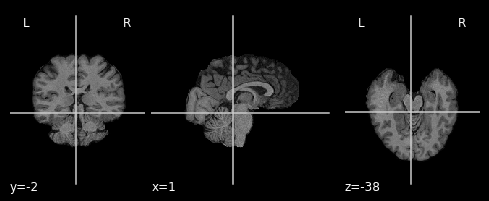

In [8]:
masked_t1 = img.math_img('a*b', a=t1, b=bm)
plot.plot_anat(masked_t1)

#### Exercise!
Try applying the mask such that the brain is removed, but the rest of the head is intact!

*Hint*:

Remember that a mask is composed of 0's and 1's, where parts of the data labelled 1 are regions to keep, and parts of the data that are 0, are to throw away.

You can do this in 2 steps:

1. Switch the 0's and 1's using an equation (simple addition/substraction) or condition (like x == 0). 
2. Apply the mask

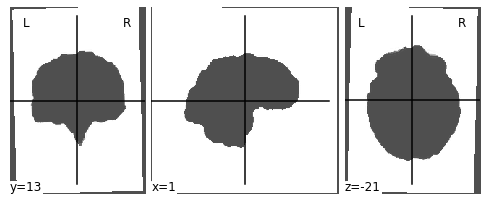

In [9]:
inverted_mask = img.math_img('1-x', x=bm)
plot.plot_anat(inverted_mask)

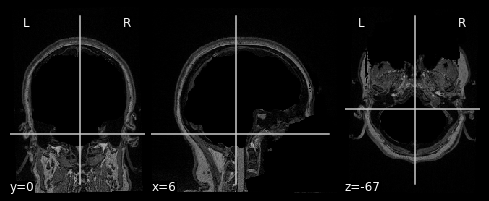

In [10]:
inverted_mask_t1 = img.math_img('a*b', a=t1, b=inverted_mask)
plot.plot_anat(inverted_mask_t1)

### Slicing

Recall that our data matrix is organized in the following manner: 

<img src="./static/images/numpy_arrays.png" alt="Drawing" align="middle" width="500px"/>

Slicing does exactly what it seems to imply. Given our 3D volume, we can pull out a 2D subset (called a "slice"). Here's an example of slicing moving from left to right via an animation:

<img src="https://upload.wikimedia.org/wikipedia/commons/5/56/Parasagittal_MRI_of_human_head_in_patient_with_benign_familial_macrocephaly_prior_to_brain_injury_%28ANIMATED%29.gif"/>

What you see here is a series of 2D images that start from the left, and move toward the right. Each frame of this GIF is a slice - a 2D subset of a 3D volume. Slicing can be useful for cases in which you'd want to loop through each MR slice and perform a computation; importantly in functional imaging data slicing is useful for pulling out timepoints as we'll see later!

***
Sourced from: https://en.wikipedia.org/wiki/Neuroimaging#/media/File:Parasagittal_MRI_of_human_head_in_patient_with_benign_familial_macrocephaly_prior_to_brain_injury_(ANIMATED).gif

***

Slicing is done easily on an image file using the attribute <code>.slicer</code> of a Nilearn <code>image</code> object. For example we can grab the $10^{\text{th}}$ slice along the x axis as follows:

In [11]:
x_slice = t1_img.slicer[10:11,:,:]

The statement $10:11$ is intentional and is required by <code>.slicer</code>. Alternatively we can slice along the x-axis using the data matrix itself:

In [12]:
t1_data = t1_img.get_data()
x_slice = t1_data[10,:,:]

This will yield the same result as above. Notice that when using the <code>t1_data</code> array we can just specify which slice to grab instead of using <code>:</code>. We can use slicing in order to modify visualizations. For example, when viewing the T1 image, we may want to specify at which slice we'd like to view the image. This can be done by specifying which coordinates to *cut* the image at:

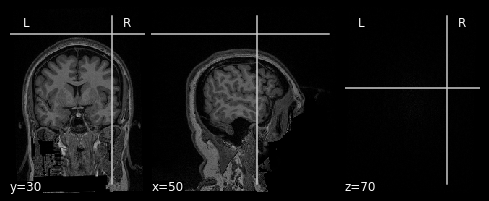

In [13]:
plot.plot_anat(t1_img,cut_coords=(50,30,70))

The <code>cut_coords</code> option specifies 3 numbers:
- The first number says cut the X coordinate at slice 50 and display (sagittal view in this case!)
- The second number says cut the Y coordinate at slice 30 and display (coronal view)
- The third number says cut the Z coordinate at slice 70 and display (axial view)

Remember <code>plot.plot_anat</code> yields 3 images, therefore <code>cut_coords</code> allows you to display where to take cross-sections of the brain from different perspectives (axial, sagittal, coronal)

***

This covers the basics of image manipulation using T1 images. To review in this section we covered:

- Basic image arithmetic
- Visualization
- Slicing

In the next section we will cover how to integrate additional modalities (functional data) to what we've done so far using <code>Nilearn</code>. Then we can start using what we've learned in order to perform analysis and visualization!